# Nonlinear Smoothing: Noisy Pendulum

In this demo, we will look at a realistic dynamical system with nonlinear state transitions: tracking a noisy single pendulum.
We translate a differential equation in state-space model form to a probabilistic model.

We are tracking a pendulum with noisy observations.
You can find this example in [Bayesian Filtering & Smoothing](https://www.cambridge.org/core/books/bayesian-filtering-and-smoothing/C372FB31C5D9A100F8476C1B23721A67) by Simon Särkkä (Ex 3.7).
Its state transitions are sinusoidal in nature and it hence, qualifies as a nonlinear dynamical system.


We can describe the system with the following differential equation:

$$\begin{align*}
\frac{d}{dt} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} x_2 \\ -g \sin(x_1) \end{bmatrix}
\end{align*}$$

where $x_1$ represents the angle $\alpha$ of the pendulum, $x_2$ represents the change in angle $d \alpha /dt$ and $g$ is gravitational acceleration.

We discretise the equation using a forward finite difference: $dx/dt = (x_{t+1} - x_{t})/\Delta t$. This produces the following discrete state transition:

$$\begin{align*}
\begin{bmatrix} x_{1,t+1} \\ x_{2,t+1} \end{bmatrix} = \begin{bmatrix} x_{1,t} + x_{2,t}\Delta t \\ x_{2,t} - g \sin(x_{1,t})\Delta t \end{bmatrix}
\end{align*}$$

We cannot observe the change in angle directly, only the angle itself (i.e. $x_{1}$).
We can select the first element of the state vector by taking the inner product between the vector $[1 \ 0]$ and the state vector $x_t$.

The observation is corrupted by white noise $v_t$:

$$y_t = x_{1,t} + v_t$$

where the white noise is sampled from a zero-mean Gaussian with precision $\tau^{-1}$:

$$v_t \sim \mathcal{N}(0, \tau^{-1}).$$

In [1]:
# Import libraries to julia workspace
using Rocket
using GraphPPL
using ReactiveMP
using Plots 
using Distributions

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1662
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1662


### Generate data

In [2]:
# Dimension: time
T = 500 # interaction: total time step count == time-series: length
Δt = 0.01 # time step: duration
rT = (1:T).*Δt

# Gravitational acceleration (SI: LT⁻²)
G = 9.81

# Measurement noise precision
noise_precision = 10.

# Initial states
x0 = [1.0, 0.0]

# Initialize data array
states = zeros(2,T)
observations = zeros(T,)

# Initialize previous state variable
prev_state = x0

for t = 1:T
    # State transition
    states[1,t] = prev_state[1] + prev_state[2]*Δt
    states[2,t] = prev_state[2] - G*sin(prev_state[1])*Δt
    
    # Observation likelihood
    observations[t] = states[1,t] + sqrt(inv(noise_precision))*randn(1)[1]
    
    # Update "previous state"
    prev_state = states[:,t]
end    

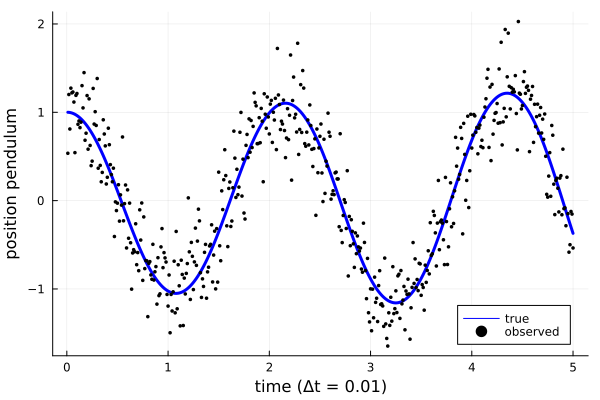

In [3]:
# Inspect data
plot(rT, states[1,:], linewidth=3, color="blue", xlabel="time (Δt = "*string(Δt)*")", ylabel="position pendulum", label="true", legend=:bottomright)
scatter!(rT, observations, color="black", markersize=2,label="observed")

In [4]:
# model of the nonlinear state transitions
g(x) = [x[1] + x[2]*Δt, x[2] - G*sin(x[1])*Δt]

τ_prior = Gamma(1.0, 1.0)

# model of the complete system dynamics
@model function noisy_pendulum(n, τ_prior=Gamma(1.0, 1.0))
    y = datavar(Float64, n)
    x = randomvar(n)
    
    τ ~ Gamma(α=τ_prior.α, β=τ_prior.θ)
    x_0 ~ MvNormal(μ=zeros(2), Σ=diageye(2))
    
    x_prev = x_0
    for i in 1:n
        x[i] ~ g(x_prev) where {meta=UT()}
        y[i] ~ Normal(μ=dot([1.0, 0.0], x[i]), γ=τ)
        x_prev = x[i]
    end
    
end
# assumed factorization of the recognition model
constraints = @constraints begin 
    q(x_0, x, τ) = q(x_0, x)q(τ)
end

Constraints:
  marginals form:
  messages form:
  factorisation:
    q(x_0, x, τ) = q(x_0, x)q(τ)
Options:
  warn = true


In [5]:
n = length(observations)
imarginals = (τ = τ_prior, )
result = inference(model = Model(noisy_pendulum, n, τ_prior), iterations=10, options=(limit_stack_depth=100, ), constraints=constraints, initmarginals=imarginals, data=(y=observations,), free_energy=true, showprogress=true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


Inference results:
-----------------------------------------
Free Energy: Real[151.89, 145.537, 145.537, 145.537, 145.537, 145.537, 145.537, 145.537, 145.537, 145.537]
-----------------------------------------
x_0 = MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNorma...
τ   = GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=251.0, b=26.440928399698326), ...
x   = Vector{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}...


In [6]:
result.posteriors[:τ]

10-element Vector{GammaShapeRate{Float64}}:
 GammaShapeRate{Float64}(a=251.0, b=26.440928399698326)
 GammaShapeRate{Float64}(a=251.0, b=25.553277479895254)
 GammaShapeRate{Float64}(a=251.0, b=25.549771888481718)
 GammaShapeRate{Float64}(a=251.0, b=25.5497580503537)
 GammaShapeRate{Float64}(a=251.0, b=25.54975799764736)
 GammaShapeRate{Float64}(a=251.0, b=25.549758007136553)
 GammaShapeRate{Float64}(a=251.0, b=25.549758003104646)
 GammaShapeRate{Float64}(a=251.0, b=25.549758002559575)
 GammaShapeRate{Float64}(a=251.0, b=25.54975801848421)
 GammaShapeRate{Float64}(a=251.0, b=25.549758010752015)

In [7]:
result.posteriors[:x]

10-element Vector{Vector{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}}:
 [MvNormalWeightedMeanPrecision(
xi: [895.3707500889998, 117.78519828301376]
Λ: [920.9550889146291 125.29256810858006; 125.29256810858006 37.97980347510365]
)
, MvNormalWeightedMeanPrecision(
xi: [907.4542591973118, 109.2546898054843]
Λ: [944.4157015250441 119.67912256968148; 119.67912256968148 35.59941294427149]
)
, MvNormalWeightedMeanPrecision(
xi: [917.8033692049822, 100.7095079385233]
Λ: [964.7694608090269 113.45784075888263; 113.45784075888263 33.412267513666734]
)
, MvNormalWeightedMeanPrecision(
xi: [925.9624054745519, 91.72624991066282]
Λ: [982.527411819774 106.52872754562914; 106.52872754562914 31.286654720127785]
)
, MvNormalWeightedMeanPrecision(
xi: [931.8728123397422, 82.41830506729245]
Λ: [997.2821656425504 98.96208621358517; 98.96208621358517 29.285121020671458]
)
, MvNormalWeightedMeanPrecision(
xi: [936.0951790855113, 72.86956427946242]
Λ: [1009.703831439838 90.9055721

In [8]:
result.posteriors[:x_0]

10-element Vector{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}:
 MvNormalWeightedMeanPrecision(
xi: [883.8160259889114, 126.73890578388865]
Λ: [896.7381978186098 130.65338955039903; 130.65338955039903 40.57775034616451]
)

 MvNormalWeightedMeanPrecision(
xi: [8983.956758019613, 1236.3456230777192]
Λ: [9013.623231883457 1240.1449321621851; 1240.1449321621851 362.5666199626227]
)

 MvNormalWeightedMeanPrecision(
xi: [9298.873292387101, 1279.6124691105215]
Λ: [9329.220903730606 1283.3663579779097; 1283.3663579779097 375.1262783850846]
)

 MvNormalWeightedMeanPrecision(
xi: [9300.160373166062, 1279.7893154915685]
Λ: [9330.510755514246 1283.5430145024477; 1283.5430145024477 375.17761421784235]
)

 MvNormalWeightedMeanPrecision(
xi: [9300.16547121761, 1279.7900149553107]
Λ: [9330.515878646336 1283.5437148437156; 1283.5437148437156 375.17781711863216]
)

 MvNormalWeightedMeanPrecision(
xi: [9300.165458194773, 1279.7900172358459]
Λ: [9330.515842215049 1283.54371454

In [9]:
m_x_t = mean.(result.posteriors[:x][end]) 
v_x_t = cov.(result.posteriors[:x][end]);

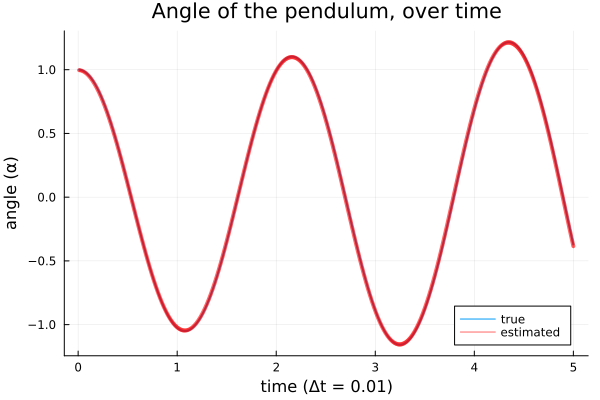

In [10]:
# Plot true states and overlay estimates
plot(rT, states[1,:], linewidth=2, xlabel="time (Δt = "*string(Δt)*")", ylabel="angle (α)", label="true", legend=:bottomright)
plot!(rT, first.(m_x_t), linewidth=4, color="red", ribbon=sqrt.(first.(v_x_t)), alpha=0.6, label="estimated")
title!("Angle of the pendulum, over time")

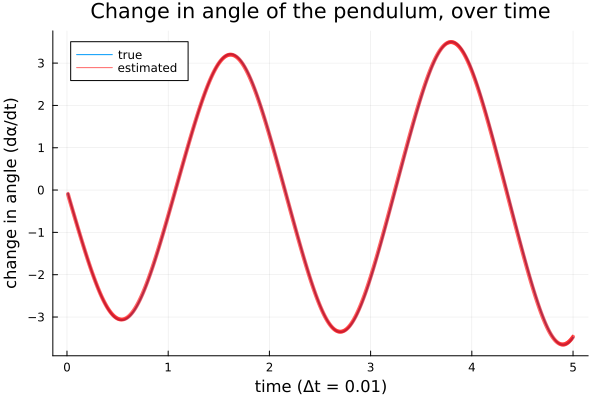

In [11]:
# Plot true states and overlay estimates
plot(rT, states[2,:], linewidth=2, xlabel="time (Δt = "*string(Δt)*")", ylabel="change in angle (dα/dt)", label="true", legend=:topleft)
plot!(rT, last.(m_x_t), linewidth=4, color="red", ribbon=sqrt.(last.(v_x_t)), alpha=0.6, label="estimated")
title!("Change in angle of the pendulum, over time")

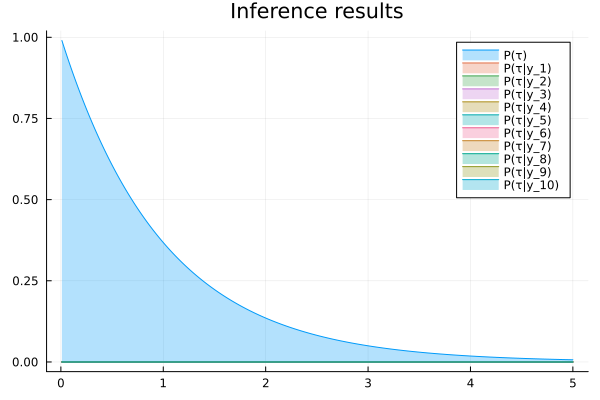

In [12]:
plot(title = "Inference results")
plot!(rT, (x) -> pdf(τ_prior, x), fillalpha=0.3, fillrange = 0, label="P(τ)")
for (i,τ̂) in enumerate(result.posteriors[:τ])
    plot!(rT, (x) -> pdf(Gamma(shape(τ̂),scale(τ̂)), x), fillalpha=0.3, fillrange = 0, label="P(τ|y_$i)")
end
plot!()

In [13]:
τ̂ = result.posteriors[:τ][end]
dist_prior = Gamma(shape(τ_prior), scale(τ_prior))
dist_post = Gamma(shape(τ̂), scale(τ̂))

Gamma{Float64}(α=251.0, θ=0.039139313944937304)

In [25]:
mean(dist_post)

9.823967800179263

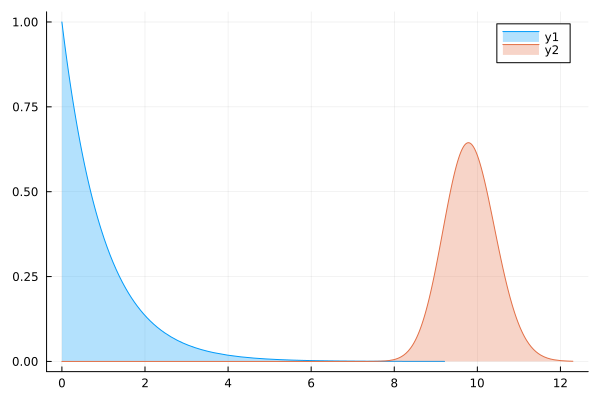

In [24]:
using StatsPlots
plot(dist_prior, fillalpha=0.3, fillrange = 0)
plot!(dist_post, fillalpha=0.3, fillrange = 0)

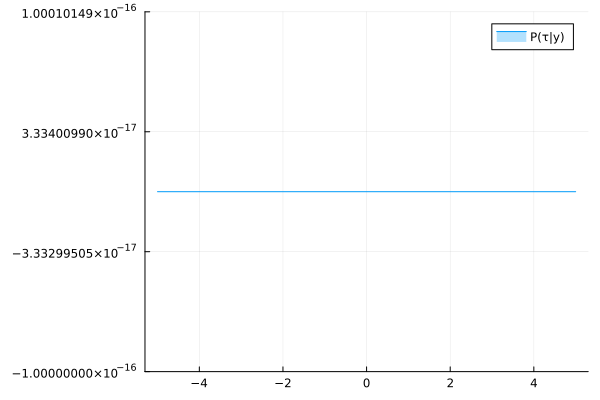

In [15]:
plot(title = "Inference results")
# plot!((x) -> pdf(dist_prior, x), fillalpha=0.3, fillrange = 0, label="P(τ)")
plot((x) -> pdf(dist_post, x), fillalpha=0.3, fillrange = 0, label="P(τ|y)")

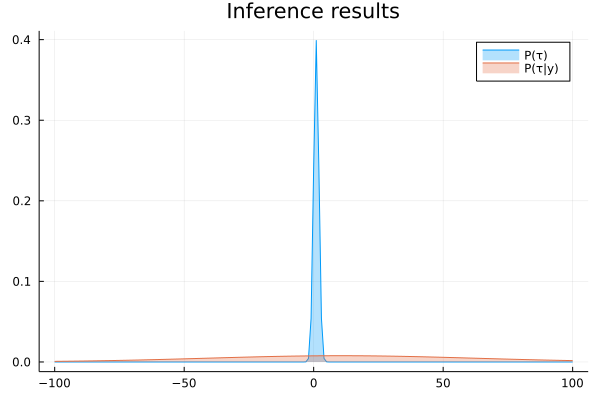

In [16]:
rT = range(-100,100)
dist_prior_N = Normal(mean(dist_prior), sqrt(var(dist_prior)))
dist_post_N = Normal(mean(dist_post), sqrt(var(dist_post)))
plot(title = "Inference results")
plot!(rT, (x) -> pdf(dist_prior_N, x), fillalpha=0.3, fillrange = 0, label="P(τ)")
plot!(rT, (x) -> pdf(dist_post_N, x), fillalpha=0.3, fillrange = 0, label="P(τ|y)")

In [18]:
mean(dist_post)

10.510660599297266

It is important to look at the evolution of free energy. Remember that free energy is a measure of uncertainty-weighted prediction error. 

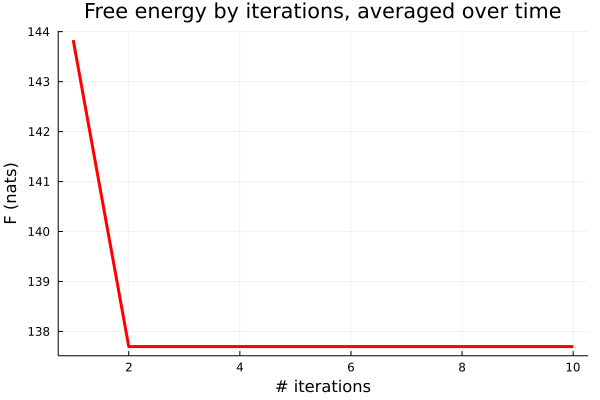

In [26]:
# Plot free energy objective
plot(result.free_energy, linewidth=3, color="red", xlabel="# iterations", ylabel="F (nats)", label="")
title!("Free energy by iterations, averaged over time")